In [17]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [18]:
image_path = "./Image"
mask_path = "./Mask"
image_path_list = sorted(os.listdir(image_path))
mask_path_list = sorted(os.listdir(mask_path))
image_path_list = [os.path.join(image_path, i) for i in image_path_list]
mask_path_list = [os.path.join(mask_path, i) for i in mask_path_list]

In [30]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Applied to both image and mask
    A.RandomRotate90(p=0.5),  # Applied to both image and mask
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=8, p=0.5),  # Applied to both image and mask
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Applied to image only
    # A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),  # Applied to image only
    # A.Perspective(scale=(0.05, 0.1), p=0.5),  # Applied to both image and mask
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=0.5),  # Applied to both image and mask
    # A.RandomRain(p=0.2),  # Applied to image only
    # A.RandomSnow(p=0.2),  # Applied to image only
    # A.RandomFog(p=0.1),  # Applied to image only
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # Applied to image only
    A.Resize(height=320, width=320),  # Applied to both image and mask
    ToTensorV2()  # Applied to both image and mask
])

class DataAugmentation(Dataset):
    def __init__(self, image_path_list, mask_path_list, transform=None):
        self.image_path_list = image_path_list
        self.mask_path_list = mask_path_list
        self.transform = transform

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_path_list[idx])
        mask = cv2.imread(self.mask_path_list[idx], cv2.IMREAD_GRAYSCALE)
        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

In [31]:
dataset = DataAugmentation(image_path_list, mask_path_list, transform)

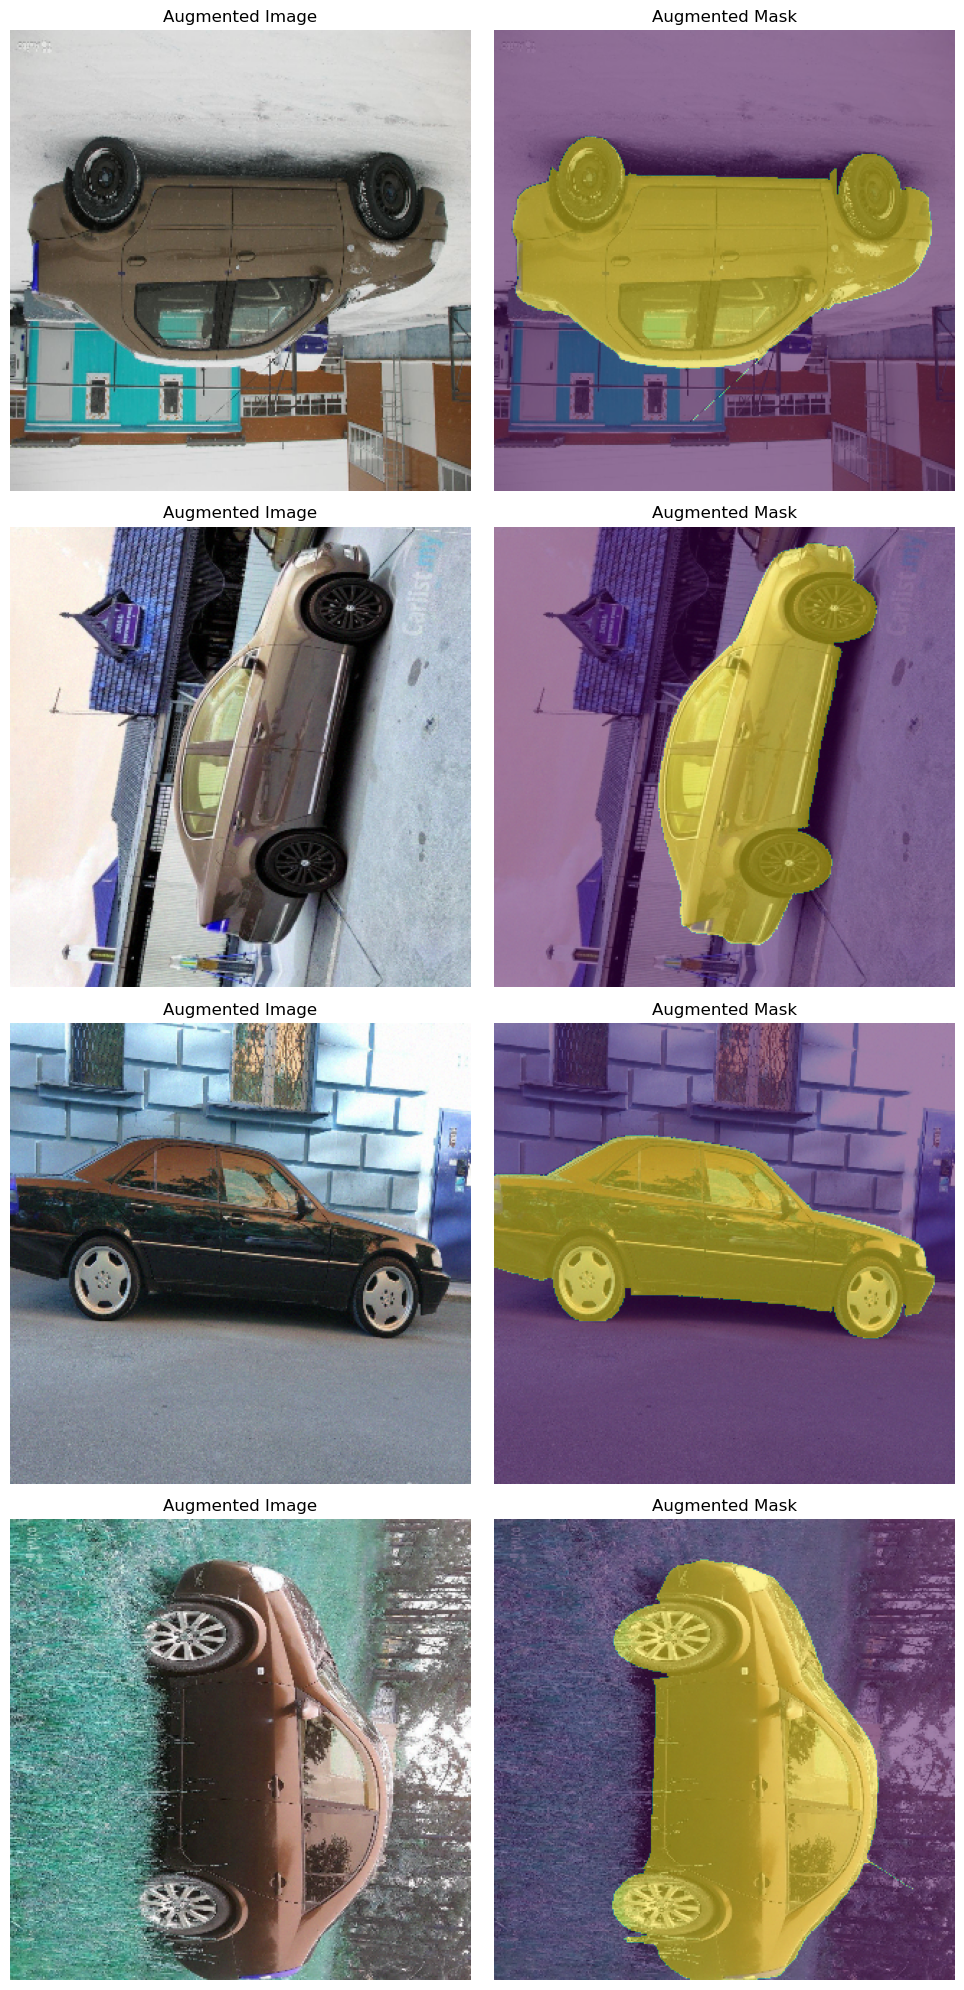

In [32]:
from torch.utils.data import DataLoader

# Create DataLoader for the training dataset
train_loader = DataLoader(dataset, batch_size=5, shuffle=True)

# Function to plot images and masks
def plot_augmented_images(images, masks):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
    for i in range(4):
        # Plot image
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title('Augmented Image')
        axes[i, 0].axis('off')

        # Plot mask
        axes[i, 1].imshow(images[i].permute(1, 2, 0))
        axes[i, 1].imshow(masks[i].squeeze(), alpha=0.5)
        axes[i, 1].set_title('Augmented Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of augmented images and masks
images, masks = next(iter(train_loader))

# Plot the augmented images and masks
plot_augmented_images(images, masks)

In [34]:
from icecream import ic
# save the images and mask from train_loader to folder synthetic_image and synthetic_mask
os.makedirs('synthetic_image', exist_ok=True)
os.makedirs('synthetic_mask', exist_ok=True)

for k in range(1,3):
    dataset = DataAugmentation(image_path_list, mask_path_list, transform)
    data_loader = DataLoader(dataset, batch_size=5, shuffle=True)
    for i, (images, masks) in enumerate(train_loader):
        # Iterate through each image and mask in the batch
        for j in range(images.size(0)):
            image = images[j].cpu().numpy()  # Convert to numpy array
            image = image.transpose(1, 2, 0)

            mask = masks[j].cpu().numpy()
            if len(mask.shape) == 2:
                mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
            # Define file paths
            # ic(image.shape, mask.shape)
            image_path = f'synthetic_image/image_{k}_{i}_{j}.png'
            mask_path = f'synthetic_mask/mask_{k}_{i}_{j}.png'

            # Save image and mask
            cv2.imwrite(image_path, image)
            cv2.imwrite(mask_path, mask)

In [23]:
len(images)

5